In [1]:
import numpy as np 
import pandas as pd 
import os
from random import randint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import glob
import imageio
import matplotlib.pyplot as plt
import PIL
import time
from keras.preprocessing.image import ImageDataGenerator
from IPython import display

In [2]:
input = 'C:/Users/KDolp/Desktop/Физтех/Data Analysis/Lab5/images'
output = 'C:/Users/KDolp/Desktop/Физтех/Data Analysis/Lab5'

strategy = tf.distribute.get_strategy()

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 100
BUFFER_SIZE = 60000
BATCH_SIZE = 120
IMAGE_SIZE = [120,120] 
CHANNELS = 3 
NOISE_DIM = 100
NUM_EXAMPLES_TO_GEN = 16

In [4]:
def decode_image(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1 
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [5]:
class DCGan(keras.Model):
    def __init__(
        self,
        pokemon_generator,
        pokemon_discriminator
    ):
        super(DCGan, self).__init__()
        self.p_gen = pokemon_generator
        self.p_disc = pokemon_discriminator
        self.seed = tf.random.normal([NUM_EXAMPLES_TO_GEN, NOISE_DIM])
        
    def compile(
        self,
        p_gen_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn
    ):
        super(DCGan, self).compile()
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        
    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.p_gen(noise, training=True)

            real_output = self.p_disc(images, training=True)
            fake_output = self.p_disc(generated_images, training=True)

            gen_loss = self.gen_loss_fn(fake_output)
            disc_loss = self.disc_loss_fn(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.p_gen.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.p_disc.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, self.p_gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.p_disc.trainable_variables))
        
        return {
            "pokemon_gen_loss": gen_loss ,
            "pokemon_disc_loss": disc_loss,
        }
    
    def train(self,dataset,epochs):
        history = []
        for epoch in range(epochs):
            start = time.time()

            for i, image_batch in enumerate(dataset):
                loss = self.train_step(image_batch)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
        display.clear_output(wait=True)
        self.save_images(epochs)
        
        return history

    def save_images(self, epoch):
        predictions = self.p_gen(self.seed, training=False)
        fig = plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        plt.savefig(output + 'image_at_epoch_{:04d}.png'.format(epoch))

In [6]:
filename_dataset = tf.data.Dataset.list_files(str(input + '/images/*.png'))
img_ds = filename_dataset.map(lambda x: decode_image(x),num_parallel_calls=AUTOTUNE)
ds = img_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)

In [7]:
def build_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(30*30*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((30, 30, 256)))
    assert model.output_shape == (None, 30, 30, 256)  

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 30, 30, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 60, 60, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    assert model.output_shape == (None, 120, 120, CHANNELS)

    return model

In [8]:
def build_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[120, 120, CHANNELS])) 
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

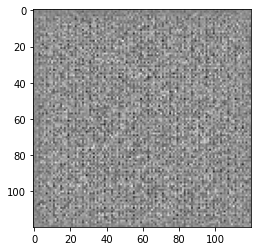

In [9]:
generator = build_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [10]:
discriminator = build_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00169244]], shape=(1, 1), dtype=float32)


In [11]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
with strategy.scope():
    def generator_loss(generated):
        return loss(tf.ones_like(generated), generated)
    
    def discriminator_loss(real, generated):
        real_loss = loss(tf.ones_like(real), real)

        generated_loss = loss(tf.zeros_like(generated), generated)

        return (real_loss + generated_loss) * 0.5

[]

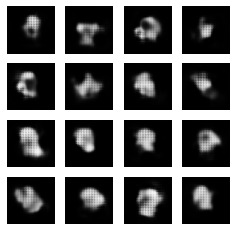

In [13]:
DCGAN = DCGan(generator,discriminator)
DCGAN.compile(
    generator_optimizer,
    discriminator_optimizer,
    generator_loss,
    discriminator_loss
)
DCGAN.train(ds, EPOCHS)

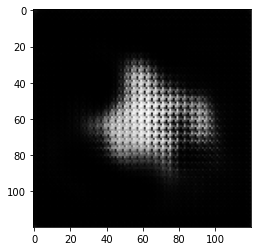

In [14]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')